# A/B-тестирование

### Задача: провести оценку результатов A/B-теста. 

- Оценить корректность проведения теста
- Проанализировать результаты теста
- Проверить пересечение тестовой аудитории с конкурирующим тестом,
- Проверить совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.
    
### Описание данных

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.


## Опишем цели исследования:
A/B тест призван определить, как повлияло на поведение пользователей внедрение улучшенной рекомендательной системы, как изменилась воронка продаж.

In [37]:
import pandas as pd
import datetime as dt
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
import seaborn as sns
register_matplotlib_converters()
import warnings
warnings.simplefilter('ignore')
from plotly import graph_objects as go
import math as mth

In [38]:
events=pd.read_csv('/Users/z/Downloads/final_ab_events.csv')
marketing_events=pd.read_csv('/Users/z/Downloads/ab_project_marketing_events.csv')
new_users=pd.read_csv('/Users/z/Downloads/final_ab_new_users.csv')
participants=pd.read_csv('/Users/z/Downloads/final_ab_participants.csv')

## Исследуем данные:
- Требуется ли преобразование типов?
- Опишите природу пропущенных значений и дубликатов, если их обнаружите.

In [39]:
display(events.head(3))
display(events.info())
display(events.isna().sum())
print('Кол-во полных дубликатов', events.duplicated().sum())
display(events.nunique())

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

Кол-во полных дубликатов 0


user_id        58703
event_dt      267268
event_name         4
details            4
dtype: int64

In [40]:
display(marketing_events)
display(marketing_events.info())

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

In [41]:
display(new_users.sample(3))
display(new_users.info())
display(new_users.isna().sum())
print('Кол-во полных дубликатов', new_users.duplicated().sum())
display(new_users.nunique())

,user_id,first_date,region,device
54589,4744D09B57722F72,2020-12-13,EU,Android
11130,5CE5F9F42D7A94D8,2020-12-14,EU,Android
25321,40F8186BEF9B3E16,2020-12-22,CIS,Android


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

user_id       0
first_date    0
region        0
device        0
dtype: int64

Кол-во полных дубликатов 0


user_id       61733
first_date       17
region            4
device            4
dtype: int64

In [42]:
display(participants.sample(3))
display(participants.info())
display(participants.isna().sum())
print('Кол-во полных дубликатов', participants.duplicated().sum())
display(participants.nunique())

,user_id,group,ab_test
15550,15643EE28C82B131,A,interface_eu_test
1164,15F57595AB51A15C,A,recommender_system_test
17663,0D134E47EE9563B5,A,interface_eu_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

user_id    0
group      0
ab_test    0
dtype: int64

Кол-во полных дубликатов 0


user_id    16666
group          2
ab_test        2
dtype: int64

Вывод: 
- По всем датафреймам данные выглядят чистыми. 
- В таблице events и new_users необходимо привести столбцы с датами в datetime. В таблице marketing_events переводить даты не обязательно, она носит ознакомительный характер.
- Пропуски в таблице events описаны в тз.
- В таблицу участников теста попали два теста, participants необходимо отсеить исследуемый recommender_system_test.

### Переведем даты в datetime

In [43]:
events['event_dt'] =  pd.to_datetime(events['event_dt'], format='%Y-%m-%d %H:%M:%S')
new_users['first_date'] =  pd.to_datetime(new_users['first_date'], format='%Y-%m-%d')

### Разобьем таблицу participants на два теста

In [44]:
participants_rec = participants.query('ab_test=="recommender_system_test"')
participants_int = participants.query('ab_test=="interface_eu_test"')

## Исследовательский анализ
- Оцените корректность проведения теста. Обратите внимание на:
     - Соответствие данных требованиям технического задания. Проверьте корректность всех пунктов технического задания.
     - Время проведения теста. Убедитесь, что оно не совпадает с маркетинговыми и другими активностями.
     - Аудиторию теста. Удостоверьтесь, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверьте равномерность распределения по тестовым группам и правильность их формирования.

### Исследуем данные

In [45]:
print('Количество событий =', events['event_name'].count())
print('Виды уникальных событий:', events['event_name'].unique()) 
print('Количество уникальных событий =', len(events['event_name'].unique()))
print('Количество уникальных пользователей =', len(events['user_id'].unique()))
print('Среднее число событий на пользователя =', round(events.groupby('user_id')['event_name'].count().mean()))
print('Минимальная дата:', events['event_dt'].min())
print('Максимальная дата:', events['event_dt'].max())
print('Интервал:', events['event_dt'].max()-events['event_dt'].min())
print('Количество пользователей по группам:','\n',participants_rec['group'].value_counts())

Количество событий = 440317
Виды уникальных событий: ['purchase' 'product_cart' 'product_page' 'login']
Количество уникальных событий = 4
Количество уникальных пользователей = 58703
Среднее число событий на пользователя = 8
Минимальная дата: 2020-12-07 00:00:33
Максимальная дата: 2020-12-30 23:36:33
Интервал: 23 days 23:36:00
Количество пользователей по группам: 
 A    3824
B    2877
Name: group, dtype: int64


### Проверим на аномалии количество событий на пользователя

,count,mean,std,min,25%,50%,75%,max
event_name,58703.0,7.500758,4.230392,1.0,4.0,6.0,9.0,36.0


Text(0.5, 1.0, 'Количество событий на пользователя')

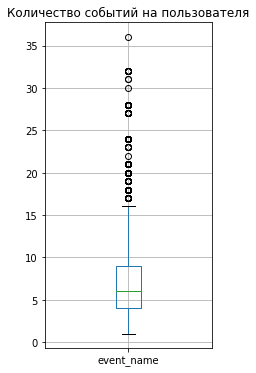

In [46]:
users_by_event_count = events.groupby('user_id')['event_name'].count().reset_index()
display(users_by_event_count.describe().T)

plt.figure(figsize=(3,6))
users_by_event_count.boxplot(column=['event_name'])
plt.title('Количество событий на пользователя')

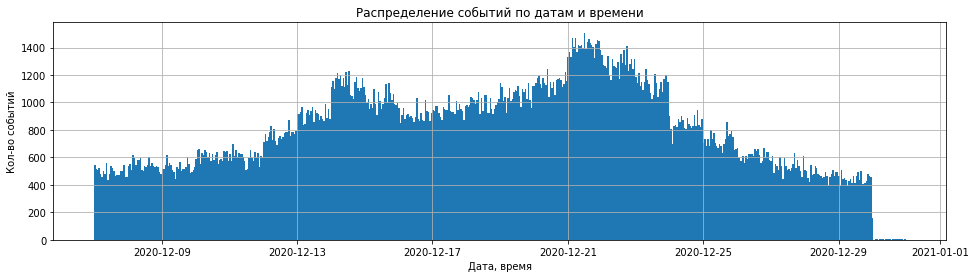

In [47]:
plt.figure(figsize=(16,4))
plt.hist(events['event_dt'], bins=552);
plt.ylabel('Кол-во событий')
plt.xlabel('Дата, время')
plt.grid()
plt.title('Распределение событий по датам и времени');

### Проверим на пересечение с конкурирующим тестом 

In [48]:
duplicate_list = set(participants_rec['user_id']) & set(participants_int['user_id'])
print('Пересечений между группами конкурирующих тестов:', len(duplicate_list))

Пересечений между группами конкурирующих тестов: 1602


### Удалим пересекающихся пользователей 

In [49]:
participants_rec = participants_rec.query('user_id not in @duplicate_list')
print('Пересечений мужду группами конкурирующих тестов:',len(set(participants_rec['user_id']) & set(participants_int['user_id'])))

Пересечений мужду группами конкурирующих тестов: 0


### Проверим на пересечение групп A и B теста 

In [50]:
participants_rec_a = participants_rec[participants_rec['group'] == 'A']
participants_rec_b = participants_rec[participants_rec['group'] == 'B']
print('Пересечений мужду группами A и B:',len(set(participants_rec_a['user_id']) & set(participants_rec_b['user_id'])))

Пересечений мужду группами A и B: 0


In [51]:
print('Участников в группе А:', participants_rec_a['user_id'].count())
print('Участников в группе B:', participants_rec_b['user_id'].count())

Участников в группе А: 2903
Участников в группе B: 2196


### Проверим аудиторию: 

In [52]:
#соединяем таблицы участников теста и новых пользователей, чтобы передать участникам теста привязку к региону. Отсеиваем лишние регионы.
participants_rec = participants_rec.merge(new_users, how='left', on='user_id').query('region == "EU"')

In [53]:
eu_new_users = new_users.query('region == "EU"')['user_id'].count()
print('Количество новых пользователей из EU =',eu_new_users)
print('Количество новых пользователей участников теста =',participants_rec['user_id'].count())
print('Доля участников теста от общего количества новых пользователей =', (participants_rec['user_id'].count()/eu_new_users*100).round(1),'%')

Количество новых пользователей из EU = 46270
Количество новых пользователей участников теста = 4749
Доля участников теста от общего количества новых пользователей = 10.3 %


# Вывод: 
- Период не соответсвует ТЗ. Начиная с полуночи 30 декабря количество событий резко снижается. За 30 декабря произошло всего 89 событий. После 30 декабря событий отсуствуют. Достоверно проанализировать можем только период с 07.12 по 29.12.
- Период проведения теста частично совпадает с Christmas&New Year Promo (2020-12-25 - 2021-01-03), но судя по графику распределения зобытий по времени промо не повлияло на тест, резкие скачки отсуствуют.
- Количество участников теста 4749, соответствует ТЗ.
- Аудитория - 10,3% от пользователей из EU.

**После отсева некондиционных данных наше тз посыпалось. Нет совпадений ни по периоду, ни по размеру группы, ни по процентному соотнощению участников.**

**Продолжать исследование считаю нецелесообразным.**

## Изучим воронку событий

### Выделим из events события по тестовой группе

In [54]:
events_rec = events.merge(participants_rec, how='inner', on='user_id')
print('Виды уникальных событий:', events_rec['event_name'].unique());
print('События по частоте:')
display(events_rec.groupby('event_name')['user_id'].count().sort_values(ascending = False));

Виды уникальных событий: ['purchase' 'product_cart' 'login' 'product_page']
События по частоте:


event_name
login           7906
product_page    4922
product_cart    2350
purchase        2348
Name: user_id, dtype: int64

### Посчитаем, сколько пользователей совершали каждое из событий. Отсортируйем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [55]:
events_id = events_rec.groupby('event_name').agg({'event_name':'count', 'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
events_id.columns = ['count_event', 'count_unique_users']
events_id['one_time_event_persent'] = (events_id['count_unique_users'] / events_rec['user_id'].nunique()* 100).round(1) # доля хотя бы раз совершивших событие
display(events_id)

,count_event,count_unique_users,one_time_event_persent
event_name,,,
login,7906,2594,100.0
product_page,4922,1632,62.9
purchase,2348,804,31.0
product_cart,2350,773,29.8


In [56]:
user_count_by_events = events_rec.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)
display(user_count_by_events)
print('Конверсия события 1 к событию 2 = ', (user_count_by_events['product_page']/user_count_by_events['login']*100).round(1),'%')
print('Конверсия события 2 к событию 3 = ', (user_count_by_events['product_cart']/user_count_by_events['product_page']*100).round(1),'%')
print('Конверсия события 3 к событию 4 = ', (user_count_by_events['purchase']/user_count_by_events['product_cart']*100).round(1),'%')
print('Конверсия события 1 к событию 4 = ', (user_count_by_events['purchase']/user_count_by_events['login']*100).round(1),'%')

event_name
login           2594
product_page    1632
purchase         804
product_cart     773
Name: user_id, dtype: int64

Конверсия события 1 к событию 2 =  62.9 %
Конверсия события 2 к событию 3 =  47.4 %
Конверсия события 3 к событию 4 =  104.0 %
Конверсия события 1 к событию 4 =  31.0 %


# Вывод: 
Последовательность событий 'login' - вход, 'product_page'- страница продукта, 'product_cart' - корзина, 'purchase' - покупка.
Конверсия показала, что переход от события product_cart к purchase более 100%. Возможно к покупке приводят какие-то еще источники кроме корзины. Другое приложение или акционные лендинги.

## Проверим, находят ли статистические критерии разницу между выборками A и B

In [57]:
successes_test = events_rec.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique').sort_values(by='A', ascending=False).reset_index()
trials_test = events_rec.groupby('group')['user_id'].nunique()
display(successes_test)
display(trials_test)

group,event_name,A,B
0,login,1939,655
1,product_page,1265,367
2,purchase,613,191
3,product_cart,589,184


group
A    1939
B     655
Name: user_id, dtype: int64

In [58]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Воронка группы А',
    y = ['login','product_page','product_cart','purchase'],
    x = [1939, 1265, 589, 613],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'Воронка группы B',
    orientation = "h",
    y = ['login','product_page','product_cart','purchase'],
    x = [655, 367, 184, 191],
    textposition = "inside",
    textinfo = "value+percent previous"))

Воронки событий по группам:
- Конверсии событий в группе A по шагам: 65,2% - 46,6% - 104,1%. 
От события 1 к событию 4 (от логина к покупке) приходит 31,6% покупателей.
- Конверсии событий в группе B по шагам: 56% - 50,1% - 103,8%.
От события 1 к событию 4 (от логина к покупке) приходит 29,2% покупателей.

В группе А переход от события login к событию product_page происходит чаще, но товары в корзину кладут наоборот реже. Как итог к покупке приходят 31,6% клиентов в группе А и 29,2% клиент в группе B.

В обеих группах к покупке приходит больше пользователей, чем на шаге корзина. Значит в исследование вмешались покупки из других источников.

Выборки отличаются в 3 раза.
    **На этой стадии стоиn остановиться, выборки неравноценны, но...**
    
Формулируем нулевую гипотезу: Между группами нет статистически значимых различий. Альтернативная гипотеза: Между группами есть статистически значимые различия.

In [59]:
alpha = 0.05

for i in successes_test.index:

    p1 = successes_test.loc[i]['A']/trials_test['A']
    p2 = successes_test.loc[i]['B']/trials_test['B']
    p_combined = (successes_test.loc[i]['A'] + successes_test.loc[i]['B']) / (trials_test['A'] + trials_test['B'])
    difference = p1 - p2 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials_test['A'] + 1/trials_test['B']))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

p-значение:  nan
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  2.457788807452843e-05
Отвергаем нулевую гипотезу: между долями есть значимая разница
p-значение:  0.24035836270660704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.26899325584838074
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


# Вывод:
Тест показал отличие выборок на стадии перехода product_page в худшую сторону. По остальным событиям мы не можем утверждать, что различия есть.

Значения изменились только в переходе на product_page в худшую сторону. По остальным событиям мы не можем утверждать различие. 
Новая рекомендательная система рекомендует что-то не интересное и уменьшила переход на страницу продукта.

# Общий вывод:

- По всем датафреймам данные выглядели чистыми. 
- В таблице events и new_users перевели столбцы с датами в datetime. В таблице marketing_events переводить даты не обязательно, она носит ознакомительный характер.
- Пропуски в таблице events описаны в тз.
- В таблицу участников теста попали два теста, participants разделили на 2 теста.

После переработки данных и отсева пересечений тестовых групп у нас рассыпалось все тз:
- Период не соответсвует ТЗ. Начиная с полуночи 30 декабря количество событий резко снижается. За 30 декабря произошло всего 89 событий. После 30 декабря событий отсуствуют. Достоверно проанализировать можем только период с 07.12 по 29.12.
- Период проведения теста частично совпадает с Christmas&New Year Promo (2020-12-25 - 2021-01-03), но судя по графику распределения зобытий по времени промо не повлияло на тест, резкие скачки отсуствуют.
- Количество участников теста 4749, соответствует ТЗ.
- Аудитория - 10,3% от пользователей из EU.

**Продолжать исследование на этом этапе в реальном проекте нецелесообразным. Но мы продолжили.**

Воронка:
- Последовательность событий 'login' - вход, 'product_page'- страница продукта, 'product_cart' - корзина, 'purchase' - покупка.
- Конверсия показала, что переход от события product_cart к purchase более 100%. Возможно к покупке приводят какие-то еще источники кроме корзины. Другое приложение или акционные лендинги. 

Воронки событий по группам:
- Конверсии событий в группе A по шагам: 65,2% - 46,6% - 104,1%. 
От события 1 к событию 4 (от логина к покупке) приходит 31,6% покупателей.
- Конверсии событий в группе B по шагам: 56% - 50,1% - 103,8%.
От события 1 к событию 4 (от логина к покупке) приходит 29,2% покупателей.

В группе А переход от события login к событию product_page происходит чаще, но товары в корзину кладут наоборот реже. Как итог к покупке приходят 31,6% клиентов в группе А и 29,2% клиент в группе B.

В обеих группах к покупке приходит больше пользователей, чем на шаге корзина.

**Этот факт так же портит нам исследование, вмешались дополнительные условия и тут можно остановиться. Но.**

Проверяем выборки:
Выборки отличаются в 3 раза: A 1939, B 655. 

**И на этой стадии тоже стоило бы остановиться, выборки явно неравноценны, но...**

Формулируем нулевую гипотезу: доли, проверяемых групп равны. Альтернативная гипотеза: доли не равны.
- Тест показал отличие выборок на стадии перехода product_page в худшую сторону. По остальным событиям мы не можем утверждать, что различия есть.

**Новая рекомендательная система рекомендует что-то не интересное и уменьшила переход на страницу продукта.**

Всё очень плохо.

⠀⠀⠈⠻⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡟⢻⡟⠛⣆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣀⣀⣀⣀⣀⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⡏⠉⠉⠙⠛⢿⡿⠋⠉⠉⠛⣿⠃⠈⠁⠐⣿⡀⡠⠊⠉⠉⠓⣼⠉⠉⣿⠋⠉⢹⠋⠉⠉⠉⡟⠉⠙⡏⠉⢹⡏⠉⢹⣷⣾⣿⣿⣿⠋⠉⠉⠉⠉⣿⡏⠉⠉⠉⠉⢻⡔⠊⠉⠉⠲⣟⠉⠙⡏⠉⢻⡔⠋⠉⠉⠢⡀⠀
⠀⠀⡇⠀⢸⠇⠀⢸⠀⠀⢸⠀⠀⢸⠀⠀⢰⣾⣿⣷⡇⠀⢸⡆⠀⢸⠀⠀⣿⠀⠀⢸⠀⠀⢰⣒⡇⠀⠀⠇⠀⢸⡇⠀⠸⠿⠥⣄⠀⢸⠀⠀⢰⠀⠀⣿⡇⠀⢰⠀⠀⢸⠁⠀⢸⠀⠀⢸⠀⠀⠀⠀⢾⠀⠀⣾⠀⠀⡇⠀
⠀⠀⡇⠀⢀⡀⠀⢻⠀⠀⢸⡿⠿⢿⠀⠀⢀⣸⣿⣿⡇⠀⢸⡇⠀⢸⡀⠀⠹⠀⠀⢸⠀⠀⢀⣀⡇⠀⠀⡀⠀⢸⡇⠀⢠⡄⠀⢸⡆⢸⠀⠀⢸⠀⠀⣿⡇⠀⢸⠀⠀⢸⠀⠀⢸⠀⠀⢸⠁⠀⠀⠀⣼⠀⠀⣿⠀⠀⡇⠀
⠀⠀⡇⠀⠸⠇⠀⢸⡀⠀⠸⠀⠀⣸⠀⠀⠸⠿⣿⣿⡇⠀⢸⠃⠀⢨⣉⣒⢻⠀⠀⢸⠀⠀⠸⠤⡇⠀⠀⡇⠀⢸⡇⠀⠸⠇⠀⢸⡇⢸⠀⠀⢸⠀⠀⡿⠇⠀⢸⠀⠀⢸⡄⠀⠸⠀⠀⡸⠀⠀⡀⠀⢹⠀⠀⢿⠀⠀⡇⠀
⠀⠀⠧⠤⠤⠤⠤⢊⣷⣤⣤⣤⠴⠻⠤⠤⠤⠤⠏⠉⠙⠤⣤⣤⠴⠛⠿⢿⣿⣤⣤⣼⣤⡤⠤⠤⠧⣤⣤⡧⠤⠼⠧⠤⠤⠤⠤⠞⠀⠸⠤⠤⠼⠤⠤⠧⠤⠤⠾⠤⠤⠼⠳⢤⣤⣤⡖⠧⠤⠤⠧⠤⠼⠗⠤⣤⠤⠞⠁⠀
⠀⠀⠀⠀⠀⠀⣴⣿⣿⠋⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⠻⢿⣿⣿⣦⣀⣾⣿⠟⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⣿⣿⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⢸⣿⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠻⢿⣿⣿⠏⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢿⣿⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⢸⣿⣿⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠻⣿⣷⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⣾⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⣿⣿⡄⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⣿⣿⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢻⣿⣷⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⣀⣤⣤⣤⣤⣤⣤⣤⣤⣤⣤⣤⣄⣀⣀⣀⣀⣀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⢿⣿⡄⠀⠀⠀⠀⣀⣤⣤⣶⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣶⣶⣤⣤⣤⣤⣀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⡟⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⢸⣿⣧⠀⣠⣴⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣶⣤⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⢘⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣶⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⢸⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣄⡀⠀⠀⠀⠀⠀⠀⠀⢿⣿⠇⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⢸⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣤⡀⠀⠀⠀⠀⣾⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⠋⠉⠉⠉⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠉⠛⠻⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣄⡀⠀⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⣻⣿⣿⣿⣿⠿⠛⠉⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠻⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣶⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⣠⣾⣿⡿⠛⠉⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠻⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡟⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⢀⣠⣾⡿⠟⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠿⣿⣿⣿⣿⣿⣿⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀
⣴⣿⡿⠋⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⡤⠶⠶⠶⠶⠤⢤⣀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⢿⣿⣿⣿⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀
⡿⠋⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡼⠋⠀⠀⠀⠀⠀⠀⠀⠀⠉⠛⢦⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠿⣿⣿⣇⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⢳⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠛⢿⣷⣄⡀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⣴⣿⣿⣿⣶⣤⡀⠀⠀⠀⢳⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣿⣦⣄⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⡶⠒⠒⠒⠲⢦⣄⠀⢸⠀⠀⠀⠀⢰⣿⣿⣿⣿⣿⣿⣿⣷⣄⠀⠈⣧⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣿⣧⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣠⠴⠒⠒⠲⢤⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡼⠋⠀⠀⠀⠀⠀⠀⠈⠛⢾⣆⠀⠀⠀⣸⣿⣿⣿⣿⣿⣿⣿⣿⣿⣆⠀⠘⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⢻⣿⣧⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⣠⠶⠋⠁⠀⠀⠀⠀⠀⠈⠛⢦⣄⠀⠀⠀⠀⠀⠀⣸⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠛⠶⠶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣤⣤⣽⣤⣤⣤⣤⣤⣤⣤⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢻⣿⡆⠀
⠀⠀⠀⠀⠀⠀⢀⡞⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢳⣄⠀⠀⠀⢠⡏⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣷⠀
⠀⠀⠀⠀⠀⠀⢸⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢧⠀⠀⣸⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣼⡏⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣿⠀
⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⢀⣤⣶⣾⣶⣶⣦⣄⡀⠀⠀⠀⠘⡇⠀⡿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣀⣠⣤⣤⣤⣤⣄⣀⠀⠀⠀⠀⠀⠀⠀⣀⣴⠟⡿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣿⠀
⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⣾⣿⣿⣿⣿⣿⣿⣿⣿⣦⡀⠀⠀⡇⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣠⣤⣤⠶⠞⠛⠉⠉⠀⠀⠀⠀⠀⠈⠉⠛⠳⠶⢤⣤⡴⠟⠋⢀⡼⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣿⠀
⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⢸⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣆⠀⣧⣸⠇⠀⠀⠀⠀⠀⠀⠀⢀⣠⡾⠋⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⡞⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣿⠀
⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⢸⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣧⣨⡟⠀⠀⠀⠀⠀⠀⢀⣴⠟⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⣤⠾⠋⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣿⠀
⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⢸⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠟⠋⠁⠀⠀⠀⠀⠀⠀⣠⡟⠁⠀⠀⠀⠀⠀⠀⠀⠀⣀⣀⣀⣀⣀⣀⣀⣠⣤⣤⡤⠶⠶⠚⠛⠉⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣿⠀
⠀⠀⠀⠀⠀⠀⢸⡀⠀⢀⣈⣿⣿⣿⡿⠿⠟⠛⠋⠉⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⡞⠉⠀⠀⠀⠀⠀⠀⠀⣀⡴⠟⠉⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣿⠀
⠀⠀⠀⠀⠀⣠⢾⡟⠛⠉⠉⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣠⣤⡤⠶⠶⠛⠋⠀⠀⠀⠀⠀⠀⣀⣴⠟⠉⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣿⠀
⠀⠀⠀⠀⠀⡏⠈⠛⠶⢦⣄⣀⡀⠀⢀⣀⣀⣤⡴⠶⠖⠚⠋⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⠞⠋⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣿⠀
⠀⠀⠀⠀⠀⢻⡄⠀⠀⠀⠈⠉⠉⠉⠉⠉⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣴⠞⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⠀